<div style="text-align: right;">
<a target="_blank" href="https://colab.research.google.com/github/hkaragah/hkaragah.github.io/blob/main/structure/structural_dynamics/modal_analysis_basic.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<div style="font-size: 0.8em; color: #555;">By Hossein Karagah</div>
<div style="font-size: 0.8em; color: #555;">© Copyright 2025 GNU GENERAL PUBLIC LICENSE.</div>
</div>

# Modal Analysis: 3-DOF System

This notebook performs modal analysis of a 3-degree-of-freedom structural system using assumed mass, damping, and stiffness values in US customary units.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh, inv

## Define System Parameters

Assume a 3-DOF mass-spring-damper system with the following properties (in US units):

* Masses in slugs (1 slug = 32.174 lb·s²/ft)
* Stiffness in lbf/in
* Damping in lbf·s/in

In [2]:
# Masses (slugs)
m1, m2, m3 = 2.0, 1.5, 1.0

# Stiffnesses (lbf/in)
k1, k2, k3 = 400.0, 300.0, 200.0

# Damping coefficients (lbf·s/in)
c1, c2, c3 = 5.0, 4.0, 3.0

## Assemble Mass, Damping, and Stiffness Matrices

In [4]:
M = np.diag([m1, m2, m3])
K = np.array([[k1 + k2, -k2, 0],
              [-k2, k2 + k3, -k3],
              [0, -k3, k3]])
C = np.array([[c1 + c2, -c2, 0],
              [-c2, c2 + c3, -c3],
              [0, -c3, c3]])

## Solve Eigenvalue Problem

I need tp solve the generalized eigenvalue problem:

$$K\phi=\omega^2M\phi$$

to get the natural frequencies and mode shapes.

In [5]:
eigenvals, mode_shapes = eigh(K, M)
omega_n = np.sqrt(eigenvals)
freq_hz = omega_n / (2 * np.pi)

for i in range(mode_shapes.shape[1]):
    mode_shapes[:, i] /= np.sqrt(mode_shapes[:, i].T @ M @ mode_shapes[:, i])

print("Natural Frequencies (Hz):", freq_hz)
print("\nNormalized Mode Shapes:")
print(mode_shapes)

Natural Frequencies (Hz): [1.14976097 2.64529086 3.74907732]

Normalized Mode Shapes:
[[-0.25709092  0.4984171  -0.43067929]
 [-0.51043088  0.24504596  0.58828518]
 [-0.69065113 -0.64272039 -0.33152905]]


## Plot Mode Shapes

Let's visualize the mode shapes to better understand deformation patterns.

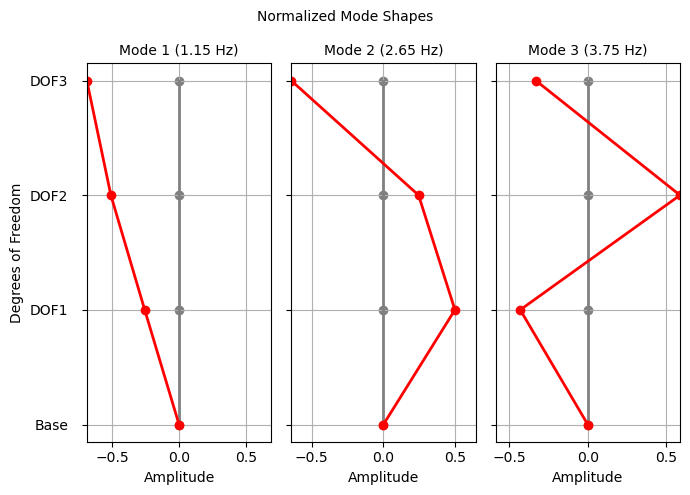

In [48]:

y = np.arange(0, 4)  # Changed to start from 0 for base
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(7, 5))

for i, ax in enumerate(axes):
    # Plot zero line
    ax.plot(np.zeros(4), y, color='grey', linewidth=2)
    ax.scatter(np.zeros(4), y, color='grey')
    
    # Plot mode shape
    ax.plot(np.append(0, mode_shapes[:, i]), y, marker='o', color='red', linewidth=2)
    
    # Set labels and style
    ax.set_title(f"Mode {i+1} ({freq_hz[i]:.2f} Hz)", fontsize=10)
    ax.set_xlabel("Amplitude")
    if i == 0:
        ax.set_ylabel("Degrees of Freedom")
    ax.grid(True)
    
    # Set symmetric x limits around 0
    max_abs = max(abs(np.append(0, mode_shapes[:, i])))
    ax.set_xlim(-max_abs, max_abs)
    
    # Set y-axis labels with more spacing
    ax.set_yticks(y)
    ax.set_yticklabels(['Base', 'DOF1', 'DOF2', 'DOF3'], fontsize=10)
    ax.tick_params(axis='y', which='major', pad=10)  # Add padding to y labels
    
fig.suptitle("Normalized Mode Shapes", fontsize=10)
plt.tight_layout()
plt.show()


## Modal Transformation

We transform the system to modal coordinates:

$$\Phi^T M \Phi = I, \Phi^T K \Phi = \Lambda$$

The damping matrix is projected into modal space as:

$$C_m = \Phi^T C \Phi$$


In [30]:
M_modal = np.eye(3)
K_modal = np.diag(eigenvals)
C_modal = mode_shapes.T @ C @ mode_shapes
print("Modal Damping Matrix:\n", C_modal)

Modal Damping Matrix:
 [[0.68464127 0.096044   0.01834847]
 [0.096044   3.86327306 0.34374602]
 [0.01834847 0.34374602 7.61875233]]


## Simulate Response Under Initial Conditions

I assume some initial displacement and velocity in physical coordinates and simulate the modal response.

* Initial displacement: $u_o = 
\begin{pmatrix}
1.0\\ 
0.0\\
0.0
\end{pmatrix}
$

* Initial velocity: $\dot{u_o}=
\begin{pmatrix}
0.0\\
0.0\\
0.0
\end{pmatrix}
$

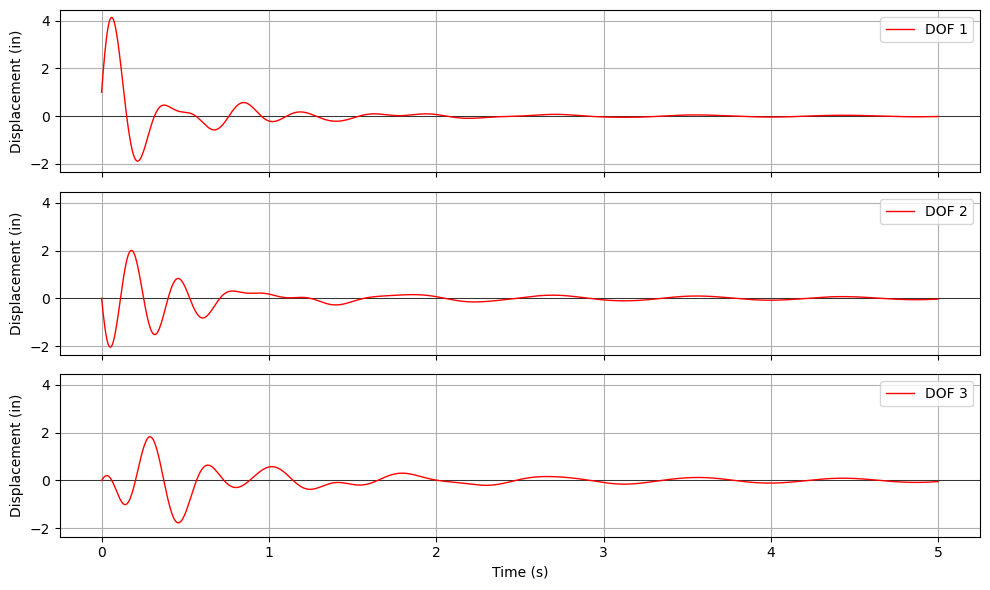

In [61]:
u0 = np.array([1.0, 0.0, 0.0])
v0 = np.zeros(3)
q0 = mode_shapes.T @ M @ u0
q0_dot = mode_shapes.T @ M @ v0

t = np.linspace(0, 5, 1000)
q_t = np.zeros((3, len(t)))

for i in range(3):
    wn = omega_n[i]
    zeta = C_modal[i, i] / (2 * wn)
    A = q0[i]
    B = (q0_dot[i] + zeta * 2 * wn * q0[i]) / np.sqrt(1 - zeta**2)
    q_t[i, :] = np.exp(-zeta * wn * t) * (
        A * np.cos(wn * np.sqrt(1 - zeta**2) * t) +
        B * np.sin(wn * np.sqrt(1 - zeta**2) * t)
    )

u_t = mode_shapes @ q_t

fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(10, 6))
for i in range(3):
    axes[i].axhline(0, color='black', linewidth=0.5)
    axes[i].plot(t, u_t[i, :], color='red', linewidth=1, label=f"DOF {i+1}")
    axes[i].legend()
    axes[i].set_ylabel("Displacement (in)")
    axes[i].grid(True)
axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()
